In [1]:
import requests
import json
import time
import pandas as pd

# Data

In [2]:
def scrape_dois(doi_list):
    base_url = 'https://api.crossref.org/works/'
    combined_data = []
    failed_dois = []

    for doi in doi_list:
        url = base_url + doi
        response = requests.get(url)

        if response.status_code == 200:
            data = response.json()
            combined_data.append(data)
            title = data['message']['title'][0]
            # print(f"DOI: {doi}\nTitle: {title}\n")
        else:
            failed_dois.append(doi)
            print(f"Failed to retrieve data for DOI: {doi}\n")

        # Delay between API requests

    # Save combined JSON output to a file
    with open("publications.json", "w") as file:
        json.dump(combined_data, file, indent=4)
    print("Combined JSON output saved to: combined_output.json")

    return combined_data, failed_dois


In [3]:
df = pd.read_csv('data/dois.csv', header=0)
dois = df['DOI'].unique().tolist()

In [4]:
len(set(dois))

402

In [5]:
# data, error = scrape_dois(dois)

# Analysis

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('darkgrid')

In [7]:
with open("data/publications.json", "r") as file:
    data = json.load(file)

In [8]:
table = []
for paper in data:
    row = {}
    row["title"] = paper['message']['title'][0]
    row["doi"] = paper['message']['DOI']
    row["authors"] = paper['message']['author']

    if paper['message']["type"] == "journal-article":
        continue
    elif paper['message']["type"] == "book-chapter":
        row['acronym'] = paper['message']["container-title"][1]
        
    else:
        row["acronym"] = paper['message']['event']["acronym"].split(" ")[0]
        
    row["year"] = paper['message']['created']['date-parts'][0][0]
    table.append(row)


In [9]:
df = pd.DataFrame(table)

### Year

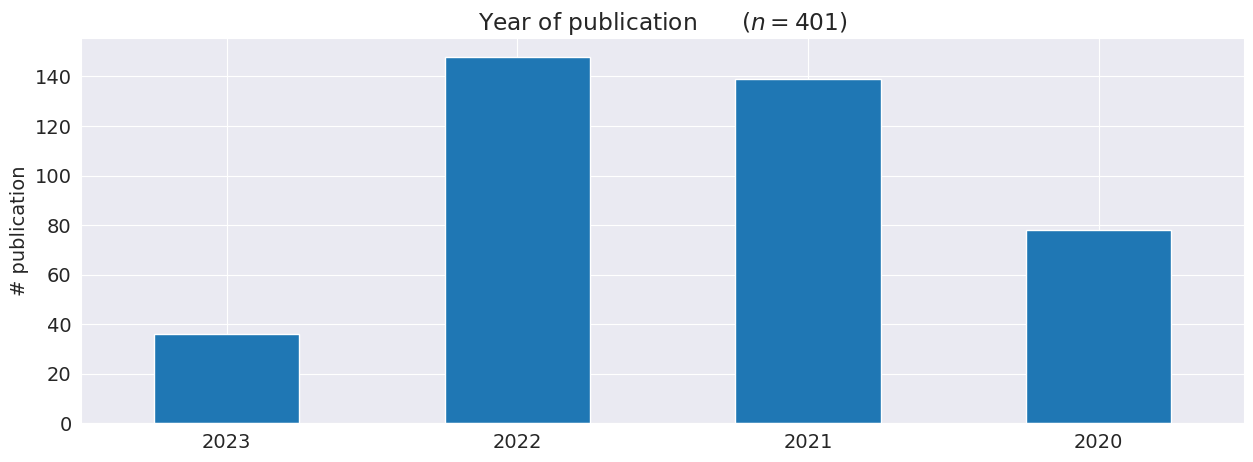

In [10]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(15, 5))
ax = df["year"].value_counts().sort_index(ascending=False).plot(kind="bar")
n = df["year"].count()
ax.set_ylabel("# publication")
ax.set_xlabel("")
ax.set_title(f"Year of publication \t ($n={n}$)")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

In [11]:
df["year"].value_counts()

2022    148
2021    139
2020     78
2023     36
Name: year, dtype: int64

### Conference

In [12]:
df["acronym"].replace("Advances in Information Retrieval", "ECIR", inplace=True)
df["acronym"].replace("Experimental IR Meets Multilinguality, Multimodality, and Interaction", "CLEF", inplace=True)

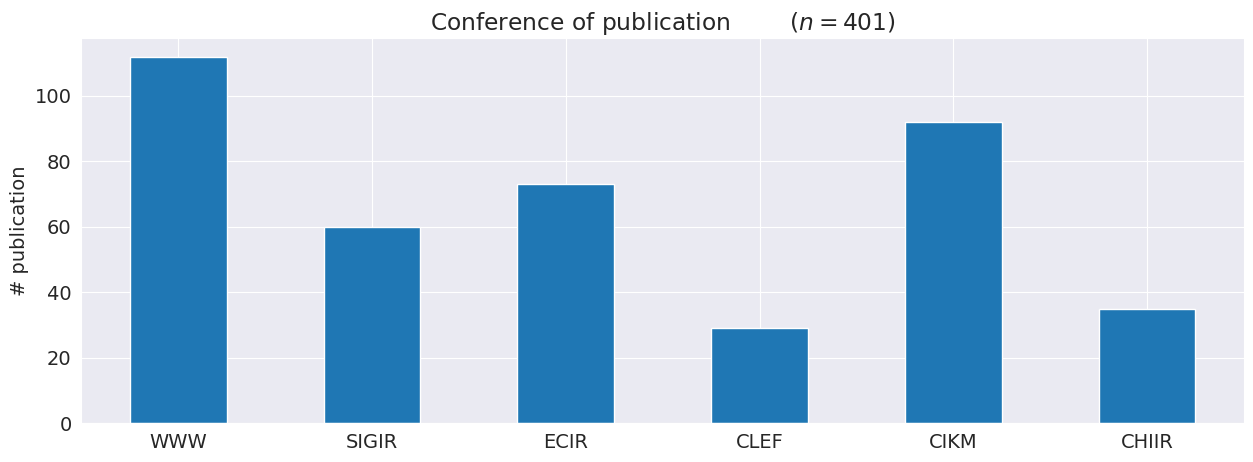

In [13]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(15, 5))
ax = df["acronym"].value_counts().sort_index(ascending=False).plot(kind="bar")
n = df["acronym"].count()
ax.set_ylabel("# publication")
ax.set_xlabel("")
ax.set_title(f"Conference of publication \t ($n={n}$)") 
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

### Authors

In [14]:
# Number of authors
df["num_authors"] = df["authors"].apply(lambda x: len(x))
df["num_authors"].describe()

count    401.000000
mean       4.985037
std        4.191035
min        1.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       36.000000
Name: num_authors, dtype: float64

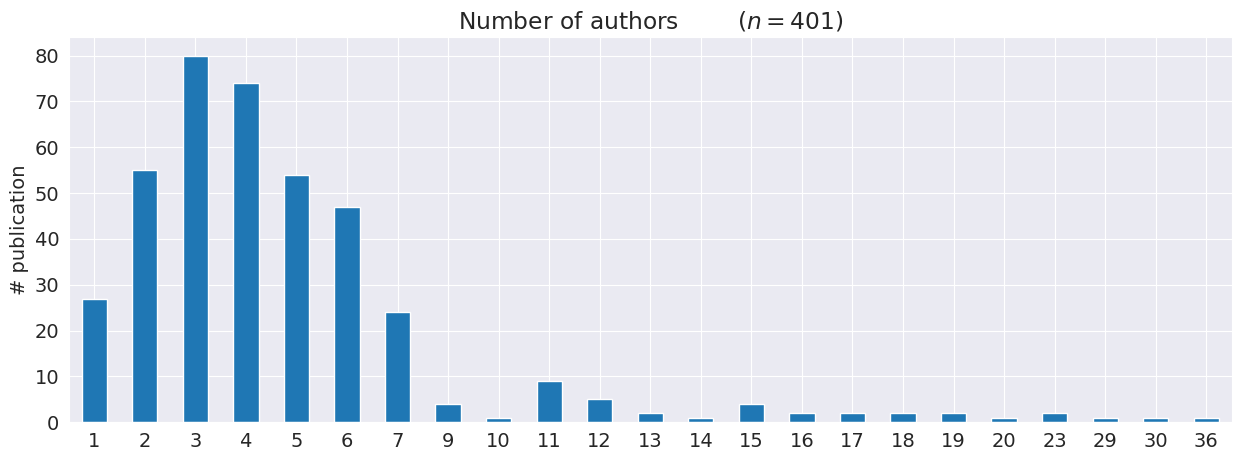

In [15]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(15, 5))
ax = df["num_authors"].value_counts().sort_index().plot(kind="bar")
n = df["num_authors"].count()
ax.set_ylabel("# publication")
ax.set_xlabel("")
ax.set_title(f"Number of authors \t ($n={n}$)") 
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

In [16]:
# Top 15 authors

In [17]:
author_df = df.explode('authors', ignore_index=True)
author_df["orcid"] = author_df["authors"].apply(lambda x: x.get("ORCID"))
author_df["name"] = author_df["authors"].apply(lambda x: x.get("given", "") + " " + x.get("family", ""))
author_df["affiliation"] = author_df["authors"].apply(lambda x: x["affiliation"][0]["name"] if x["affiliation"] else None)
author_df.drop("authors", axis=1, inplace=True)

In [18]:
author_df.groupby("name").count().sort_values("title", ascending=False).head(15)

,title,doi,acronym,year,num_authors,orcid,affiliation
name,,,,,,,
Martin Potthast,27,27,27,27,27,2,9
Benno Stein,26,26,26,26,26,3,11
Matthias Hagen,21,21,21,21,21,0,10
Maik Fröbe,17,17,17,17,17,1,6
Alexander Bondarenko,12,12,12,12,12,1,5
Gerhard Weikum,12,12,12,12,12,0,11
Andrew Yates,12,12,12,12,12,0,7
Janek Bevendorff,9,9,9,9,9,0,3
Evgeny Kharlamov,9,9,9,9,9,0,9


In [19]:
# Papers per author

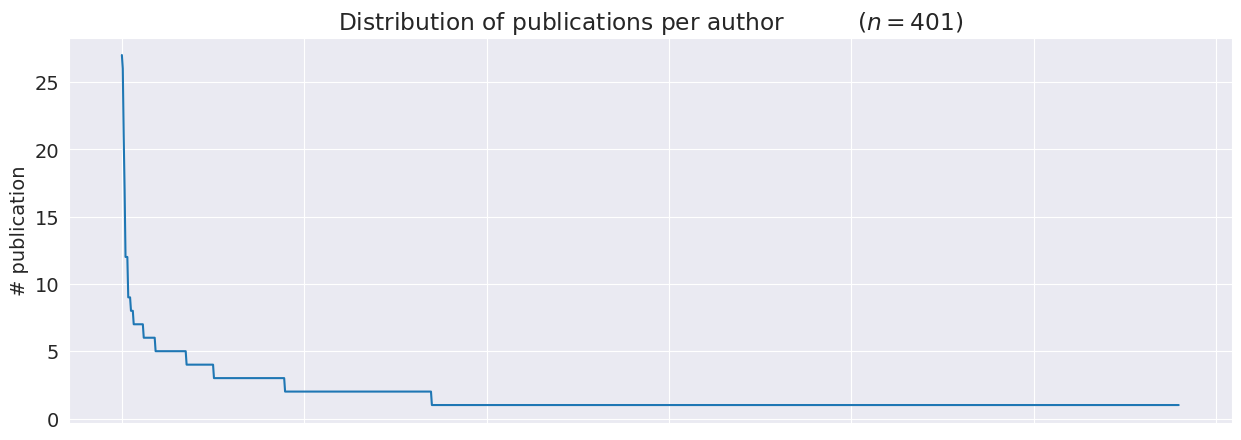

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
author_count = author_df.groupby("name").count().sort_values("title", ascending=False)["title"].plot(kind="line")
ax.set_ylabel("# publication")
ax.set_xlabel("")
ax.set_title(f"Distribution of publications per author \t ($n={n}$)") 
_ = plt.setp( ax.get_xticklabels(), visible=False)

In [21]:
# affiliation

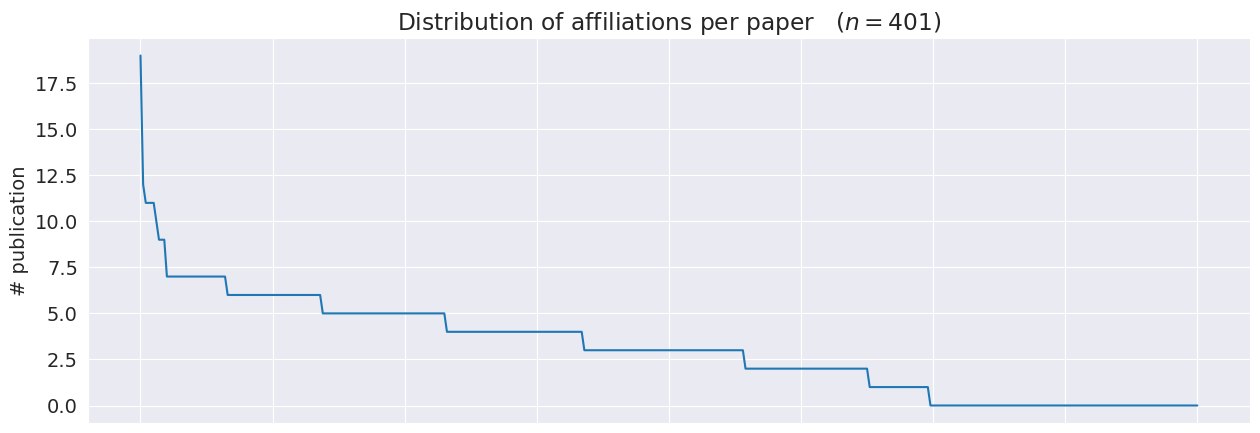

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))
author_count = author_df.groupby("doi").count().sort_values("affiliation", ascending=False)["affiliation"].plot(kind="line")
ax.set_ylabel("# publication")
ax.set_xlabel("")
ax.set_title(f"Distribution of affiliations per paper \t ($n={n}$)") 
_ = plt.setp( ax.get_xticklabels(), visible=False)

In [23]:
# number different affiliations per paper
author_df.affiliation.isna().sum()

767

In [24]:
# interpolate affiliations

In [25]:
grouped = author_df.groupby('name')
# Iterate over each group
for group_name, group_df in grouped:
    unique_values = group_df['affiliation'].dropna().unique()
    if len(unique_values) == 1:
        author_df.loc[group_df.index, 'affiliation'] = unique_values[0]

In [27]:
author_df[author_df.name == "Philipp Schaer"][["title", "name", "affiliation", "doi"]]

,title,name,affiliation,doi
1006,How to Measure the Reproducibility of System-o...,Philipp Schaer,"TH Köln, Cologne, Germany",10.1145/3397271.3401036
1225,ir_metadata: An Extensible Metadata Schema for...,Philipp Schaer,"TH Köln, Köln, Germany",10.1145/3477495.3531738
1258,Overview of LiLAS 2020 – Living Labs for Acade...,Philipp Schaer,None,10.1007/978-3-030-58219-7_24
1332,Evaluating Elements of Web-Based Data Enrichme...,Philipp Schaer,None,10.1007/978-3-030-85251-1_5
1333,Overview of LiLAS 2021 – Living Labs for Acade...,Philipp Schaer,None,10.1007/978-3-030-85251-1_25
1545,Living Lab Evaluation for Life and Social Scie...,Philipp Schaer,None,10.1007/978-3-030-72240-1_77
1555,repro_eval: A Python Interface to Reproducibil...,Philipp Schaer,None,10.1007/978-3-030-72240-1_51
1766,Validating Simulations of User Query Variants,Philipp Schaer,None,10.1007/978-3-030-99736-6_6


In [28]:
df[df["doi"] == "10.1145/3397271.3401036"].iloc[0]["authors"]

[{'given': 'Timo',
  'family': 'Breuer',
  'sequence': 'first',
  'affiliation': [{'name': 'TH Köln, Cologne, Germany'}]},
 {'given': 'Nicola',
  'family': 'Ferro',
  'sequence': 'additional',
  'affiliation': [{'name': 'University of Padua, Padua, Italy'}]},
 {'given': 'Norbert',
  'family': 'Fuhr',
  'sequence': 'additional',
  'affiliation': [{'name': 'Universität Duisburg-Essen, Duisburg, Germany'}]},
 {'given': 'Maria',
  'family': 'Maistro',
  'sequence': 'additional',
  'affiliation': [{'name': 'University of Copenhagen, Copenhagen, Denmark'}]},
 {'given': 'Tetsuya',
  'family': 'Sakai',
  'sequence': 'additional',
  'affiliation': [{'name': 'Waseda University, Tokyo, Japan'}]},
 {'given': 'Philipp',
  'family': 'Schaer',
  'sequence': 'additional',
  'affiliation': [{'name': 'TH Köln, Cologne, Germany'}]},
 {'given': 'Ian',
  'family': 'Soboroff',
  'sequence': 'additional',
  'affiliation': [{'name': 'National Institute of Standards and Technology (NIST), Gaithersburg, MD, USA

# Title

In [29]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

In [30]:
def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [31]:
df["title_clean"] = df["title"].apply(remove_punctuation)

In [32]:
stemmer = SnowballStemmer('english')
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), tokenizer=stemmer.stem)

In [33]:
tfidf_matrix = vectorizer.fit_transform(df['title_clean'])

/home/jueri/miniconda3/envs/geo/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/jueri/miniconda3/envs/geo/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(


In [34]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [35]:
df = pd.concat([df, tfidf_df], axis=1)

# Gephi export

In [50]:
df["names"] = df["authors"].apply(lambda x: ", ".join([author.get("given", "") + " " + author.get("family", "") for author in x]))

In [52]:
df["names"].to_csv("export/gephi.csv", index=False)

# Json Export

In [48]:
with open("export/IR_Institute_metadata.json", "w") as file:
    json.dump(table, file)

# Graph

In [38]:
import networkx as nx

In [49]:
df["names"] = df["authors"].apply(lambda x: [author.get("given", "") + " " + author.get("family", "") for author in x])

In [40]:
articles = []
for row in df[["title", "names"]].iterrows():
    articles.append({"authors": row[1]["names"]})

In [41]:
# Initialize the graph
co_author_network = nx.Graph()

for article in articles[:10]:
    authors = article['authors']
    
    # Add nodes for authors
    for author in authors:
        co_author_network.add_node(author)
    
    # Add edges for co-authorship
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            co_author_network.add_edge(authors[i], authors[j])

# Print the nodes and edges
print("Nodes:", co_author_network.nodes())
print("Edges:", co_author_network.edges())


Nodes: ['Yuan Ma', 'Tim Donkers', 'Timm Kleemann', 'Jürgen Ziegler', 'Niklas Deckers', 'Maik Fröbe', 'Johannes Kiesel', 'Gianluca Pandolfo', 'Christopher Schröder', 'Benno Stein', 'Martin Potthast', 'Marcel Gohsen', 'Mariam Korashi', 'Jan Ehlers', 'Markus Bink', 'Sebastian Schwarz', 'Tim Draws', 'David Elsweiler', 'Wolfgang Gritz', 'Christian Otto', 'Anett Hoppe', 'Georg Pardi', 'Yvonne Kammerer', 'Ralph Ewerth', 'Sebastian Schultheiß', 'Helena Häußler', 'Toine Bogers', 'Maria Gäde', 'Mark Michael Hall', 'Marijn Koolen', 'Vivien Petras', 'Birger Larsen', 'Mark M. Hall', 'Volker Bernhard', 'Josef Roth']
Edges: [('Yuan Ma', 'Tim Donkers'), ('Yuan Ma', 'Timm Kleemann'), ('Yuan Ma', 'Jürgen Ziegler'), ('Tim Donkers', 'Timm Kleemann'), ('Tim Donkers', 'Jürgen Ziegler'), ('Timm Kleemann', 'Jürgen Ziegler'), ('Niklas Deckers', 'Maik Fröbe'), ('Niklas Deckers', 'Johannes Kiesel'), ('Niklas Deckers', 'Gianluca Pandolfo'), ('Niklas Deckers', 'Christopher Schröder'), ('Niklas Deckers', 'Benno Ste

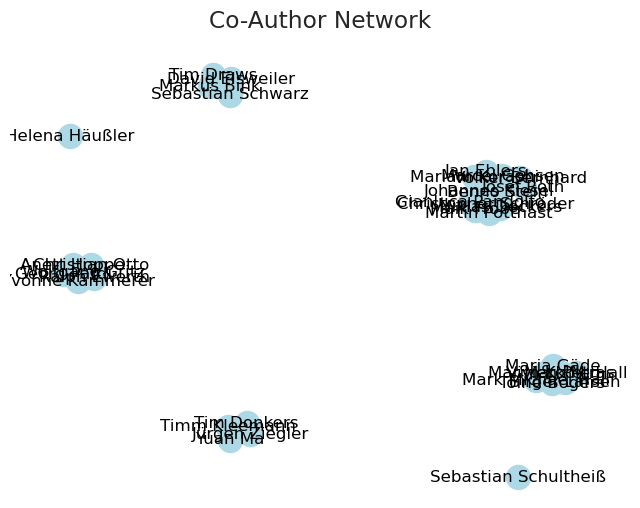

In [42]:
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(co_author_network)  # Layout algorithm for node positioning
nx.draw_networkx(co_author_network, pos=pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title('Co-Author Network')
plt.axis('off')
plt.show()